In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

In [2]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, GRU
import keras.backend as K 
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import SGD

In [3]:
import datetime

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout

# 데이터 로드

In [25]:
train1

,smart_farm.yy,smart_farm.mm,smart_farm.dd,smart_farm.hh,smart_farm.nn,smart_farm.insolation,smart_farm.out_tmperature,smart_farm.out_humidity,smart_farm.wind_speed,smart_farm.wind_direction,...,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2021,11,26,0,0,-2.7,5.8,67,0.0,325,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
1,2021,11,26,0,1,-2.9,5.8,67,0.4,344,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2,2021,11,26,0,2,-3.0,5.7,67,0.9,105,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
3,2021,11,26,0,3,-3.0,5.7,67,1.3,123,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
4,2021,11,26,0,4,-2.8,5.7,67,0.9,123,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132475,2022,2,28,23,55,-2.7,4.1,51,0.0,57,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
132476,2022,2,28,23,56,-2.7,4.1,52,0.4,57,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
132477,2022,2,28,23,57,-2.7,4.1,52,0.4,40,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
132478,2022,2,28,23,58,-2.6,4.1,52,0.4,36,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8


In [10]:
curr_dir = os.getcwd()
curr_dir

forders_tr = os.listdir(curr_dir+"\\data")
forders_tr

df = pd.read_csv(os.path.join(curr_dir+"\\data\\")+forders_tr[0])
df = df.drop(df.columns[0], axis=1)
df

df2022 = df[df['smart_farm.yy']==2022]
df2022
df202203 = df2022[df2022['smart_farm.mm']==3]
df202203

train = df.iloc[:132480]
train = train.reset_index()
train = train.drop('index', axis=1)

test = df.iloc[132480:]
test = test[test['smart_farm.dd']!=15]        # 15일자 제외
test = test.reset_index()
test = test.drop('index', axis=1)
test

# train1 = train.dropna(axis=0)
train1 = train.interpolate(method ='linear')     
# train 결측치 채운 이유=> 시간 별 데이터 중간중간 결측돼서 이를 이용해서 일자 예측하려면 채워줘야하기 때문.
test1 = test.interpolate(method ='linear') 

submission = pd.read_csv('2-1_검증데이터셋.csv')
submission1 = submission.copy()
submission1             # "년도 월 일 시 분 => 년도 월 일"  예측

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,NaN,NaN
1,2022,3,5,NaN,NaN
2,2022,3,6,NaN,NaN
3,2022,3,7,NaN,NaN
4,2022,3,8,NaN,NaN
5,2022,3,9,NaN,NaN
6,2022,3,10,NaN,NaN
7,2022,3,11,NaN,NaN
8,2022,3,12,NaN,NaN
9,2022,3,13,NaN,NaN


In [3]:
train1[train1.columns[-1]].value_counts()

0.500000    28429
0.000000    25599
0.100000    23461
0.400000    11202
0.600000     9269
            ...  
0.344715        1
0.339024        1
0.333333        1
0.327642        1
0.400847        1
Name: smart_farm.heat_supply, Length: 507, dtype: int64

In [4]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132480 entries, 0 to 132479
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   smart_farm.yy                               132480 non-null  int64  
 1   smart_farm.mm                               132480 non-null  int64  
 2   smart_farm.dd                               132480 non-null  int64  
 3   smart_farm.hh                               132480 non-null  int64  
 4   smart_farm.nn                               132480 non-null  int64  
 5   smart_farm.insolation                       132480 non-null  float64
 6   smart_farm.out_tmperature                   132480 non-null  float64
 7   smart_farm.out_humidity                     132480 non-null  int64  
 8   smart_farm.wind_speed                       132480 non-null  float64
 9   smart_farm.wind_direction                   132480 non-null  int64  
 

# 외부 데이터 넣기

In [6]:
soil = pd.read_csv('OBS_AAOS_TIM_20220802210224.csv', encoding='cp949')       # 해당 시간 당 지점별 평균 내기
soil

,지점,지점명,일시,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%)
0,119,수원,2021-11-26 00:00,4.5,25.9,24.1,26.6
1,119,수원,2021-11-26 01:00,4.5,25.9,24.1,26.6
2,119,수원,2021-11-26 02:00,4.6,25.9,24.1,26.6
3,119,수원,2021-11-26 03:00,4.6,25.9,24.1,26.6
4,119,수원,2021-11-26 04:00,4.5,25.9,24.1,26.6
...,...,...,...,...,...,...,...
28822,980,강정,2022-03-20 19:00,23.5,34.3,38.0,40.8
28823,980,강정,2022-03-20 20:00,23.6,34.3,38.0,40.8
28824,980,강정,2022-03-20 21:00,23.6,34.3,38.0,40.8
28825,980,강정,2022-03-20 22:00,23.6,34.8,38.8,40.8


In [7]:
stn = list(set(soil['지점'].values))
stn

[129, 258, 970, 972, 973, 974, 977, 978, 980, 119, 702]

In [8]:
# 인덱스 리셋, 지점/지점명/일시 컬럼 삭제 ==> 추후 일시 컬럼 복구(df간의 계산 위해)
soil_df = []
for i in range(len(stn)):
    df = soil[soil['지점']==stn[i]]
    df = df.reset_index()
    df = df.drop('index', axis=1)
    df = df.drop(['지점', '지점명', '일시'], axis=1)
    soil_df.append(df)
soil_df[0]

,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%)
0,15.6,16.8,28.3,35.0
1,15.5,16.6,28.1,35.0
2,15.5,16.6,28.1,35.0
3,15.6,16.6,28.1,35.0
4,15.6,16.5,28.1,35.0
...,...,...,...,...
2488,20.6,23.2,31.6,32.9
2489,20.6,23.3,31.5,32.9
2490,20.6,23.3,31.6,32.9
2491,20.7,23.2,31.6,32.9


In [9]:
a = []
for i in range(len(soil_)):
    a.append(len(soil_[i]['일시'].values))     # 중간에 없는 일자의 관측소도 있음.(2710가 최대=>나머지는 0으로 채움.)
a

NameError: name 'soil_' is not defined

In [10]:
# stn     # 129, 972, 974, 978, 702 => 전처리할 파일 _1

In [11]:
ind_1 = [index for index,value in enumerate(a) if value != max(a)]
ind_1

[]

In [12]:
stn_1 = []
for i in range(len(ind_1)):
    stn_1.append(stn[ind_1[i]])
stn_1

[]

In [13]:
for i in range(len(stn)):
    df = soil[soil['지점']==stn[i]]
    df.to_csv(os.path.join('stn\\'+str(stn[i])+'.csv'), index=False)
    
## 임의로 비어 있는 부분 nan 표기 엑셀 vlookup이용해서
## 그 후 0으로 채우고 => 평균화

In [14]:
stn[ind_1[1]]

IndexError: list index out of range

In [15]:
# 참고로, 앞부분 NAN은 안 중요 => 모두 0으로 채워도 됨. 뒷부분 열만 쓰므로
for i in range(len(stn_1)):
    df = pd.read_csv(os.path.join('stn\\'+str(stn_1[i])+'_1.csv'), encoding='cp949')
    df = df.drop(list(df.columns[2:8]), axis=1) 
    df = df.fillna(0)
    df = df.drop(['지점', '지점명', '일시.1'], axis=1)
    df.columns = soil_df[1].columns
    soil_df[ind_1[i]] = df

In [352]:
# 일자 저장
df = pd.read_csv(os.path.join('stn\\'+str(stn_1[0])+'_1.csv'), encoding='cp949')
day = df['일시.1'].values
day

array(['2021-11-26 0:00', '2021-11-26 1:00', '2021-11-26 2:00', ...,
       '2022-03-20 21:00', '2022-03-20 22:00', '2022-03-20 23:00'],
      dtype=object)

In [16]:
# 하나의 데이터 프레임으로(빈 값 하나 만들어서)
soil_df1 = soil_df[0].copy()
for i in range(len(soil_df[0].columns)):
    soil_df1[soil_df[0].columns[i]] = 0
soil_df1

for i in range(len(soil_df)):
    soil_df1 = soil_df1 + soil_df[i]
soil_df1 = soil_df1/len(soil_df)
soil_df1  

,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%)
0,21.400000,22.190909,21.800000,24.372727
1,21.327273,22.172727,21.900000,24.381818
2,21.281818,22.127273,21.745455,24.372727
3,21.227273,22.109091,21.718182,24.372727
4,21.163636,22.072727,21.700000,24.363636
...,...,...,...,...
2705,NaN,NaN,NaN,NaN
2706,NaN,NaN,NaN,NaN
2707,NaN,NaN,NaN,NaN
2708,NaN,NaN,NaN,NaN


In [354]:
soil_df1['일자'] = day
soil_df1

,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),일자
0,21.400000,22.190909,21.800000,24.372727,2021-11-26 0:00
1,21.327273,22.172727,21.900000,24.381818,2021-11-26 1:00
2,21.281818,22.127273,21.745455,24.372727,2021-11-26 2:00
3,21.227273,22.109091,21.718182,24.372727,2021-11-26 3:00
4,21.163636,22.072727,21.700000,24.363636,2021-11-26 4:00
...,...,...,...,...,...
2705,20.218182,21.172727,19.836364,22.627273,2022-03-20 19:00
2706,20.172727,21.109091,19.800000,22.627273,2022-03-20 20:00
2707,20.190909,21.072727,19.809091,22.609091,2022-03-20 21:00
2708,20.136364,21.045455,19.854545,22.618182,2022-03-20 22:00


In [355]:
# 본 데이터12월 빠진 데이터 있음. (22,23,24)
# 외부 데이터 3월 15일 제거해야함

In [356]:
d = soil_df1[soil_df1['일자'] == '2021-12-22 0:00'].index[0]
d1 = soil_df1[soil_df1['일자'] == '2022-03-15 0:00'].index[0]
# print(d1)

for i in range(d, d+24*3):
    soil_df1 = soil_df1.drop(i,axis=0)
    
for i in range(d1, d1+24):
    soil_df1 = soil_df1.drop(i,axis=0)
    
# soil_df1.iloc[d:d+24*3]
# soil_df1.iloc[d1:d1+24]
soil_df1 = soil_df1.reset_index()
soil_df1 = soil_df1.drop('index', axis=1)
soil_df1

,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),일자
0,21.400000,22.190909,21.800000,24.372727,2021-11-26 0:00
1,21.327273,22.172727,21.900000,24.381818,2021-11-26 1:00
2,21.281818,22.127273,21.745455,24.372727,2021-11-26 2:00
3,21.227273,22.109091,21.718182,24.372727,2021-11-26 3:00
4,21.163636,22.072727,21.700000,24.363636,2021-11-26 4:00
...,...,...,...,...,...
2609,20.218182,21.172727,19.836364,22.627273,2022-03-20 19:00
2610,20.172727,21.109091,19.800000,22.627273,2022-03-20 20:00
2611,20.190909,21.072727,19.809091,22.609091,2022-03-20 21:00
2612,20.136364,21.045455,19.854545,22.618182,2022-03-20 22:00


In [394]:
d = soil_df1[soil_df1['일자'] == '2022-03-01 0:00'].index[0]
d1 = soil_df1[soil_df1['일자'] == '2022-03-04 0:00'].index[0]
soil_train = soil_df1.iloc[:d]
soil_test = soil_df1.iloc[d1:]

soil_test = soil_test.reset_index()
soil_test = soil_test.drop('index', axis=1)
soil_test

,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),일자
0,12.981818,16.572727,14.881818,18.472727,2022-03-04 0:00
1,12.890909,16.536364,14.881818,18.481818,2022-03-04 1:00
2,12.854545,16.509091,14.872727,18.481818,2022-03-04 2:00
3,12.745455,16.490909,14.890909,18.490909,2022-03-04 3:00
4,12.645455,16.472727,14.890909,18.490909,2022-03-04 4:00
...,...,...,...,...,...
374,20.218182,21.172727,19.836364,22.627273,2022-03-20 19:00
375,20.172727,21.109091,19.800000,22.627273,2022-03-20 20:00
376,20.190909,21.072727,19.809091,22.609091,2022-03-20 21:00
377,20.136364,21.045455,19.854545,22.618182,2022-03-20 22:00


In [392]:
soil_train.to_csv('train_prep.csv', index=False)
soil_test.to_csv('test_prep.csv', index=False)

In [359]:
# soil_train.to_csv('train_prep.csv', index=False)
i = pd.date_range('2021-11-26', periods=2352, freq='1H')
i

DatetimeIndex(['2021-11-26 00:00:00', '2021-11-26 01:00:00',
               '2021-11-26 02:00:00', '2021-11-26 03:00:00',
               '2021-11-26 04:00:00', '2021-11-26 05:00:00',
               '2021-11-26 06:00:00', '2021-11-26 07:00:00',
               '2021-11-26 08:00:00', '2021-11-26 09:00:00',
               ...
               '2022-03-03 14:00:00', '2022-03-03 15:00:00',
               '2022-03-03 16:00:00', '2022-03-03 17:00:00',
               '2022-03-03 18:00:00', '2022-03-03 19:00:00',
               '2022-03-03 20:00:00', '2022-03-03 21:00:00',
               '2022-03-03 22:00:00', '2022-03-03 23:00:00'],
              dtype='datetime64[ns]', length=2352, freq='H')

# 외부 데이터에도 없는 날짜 채워줘야함_train

In [4]:
i = pd.date_range('2021-11-26', periods=2280, freq='1H')         #2352
i
day1 = pd.DataFrame(i)
day1.columns = ['일자']
day1
# day1.to_csv('day.csv', index=False)

,일자
0,2021-11-26 00:00:00
1,2021-11-26 01:00:00
2,2021-11-26 02:00:00
3,2021-11-26 03:00:00
4,2021-11-26 04:00:00
...,...
2275,2022-02-28 19:00:00
2276,2022-02-28 20:00:00
2277,2022-02-28 21:00:00
2278,2022-02-28 22:00:00


In [5]:
soil_train1 = pd.read_csv('train_prep_1.csv', encoding='cp949')
soil_train1
soil_train1 = soil_train1.drop(list(soil_train1.columns[:6]), axis=1) 
# soil_train1 = soil_train1.fillna(0)
soil_train1 = soil_train1.drop(['일자.1'], axis=1)
soil_train1.columns = soil_df[1].columns
soil_train1.drop(2280, axis=0, inplace=True)

NameError: name 'soil_df' is not defined

In [ ]:
soil_train1 = soil_train1.interpolate(method ='linear')     # interpolation 적용하고 특정 날짜를 빼야 의미가 상통(전처리=>다시 날짜빼줘야함)
soil_train1

soil_train1['일자'] = i
soil_train1

In [ ]:
d = soil_train1[soil_train1['일자'] == '2021-12-22 0:00'].index[0]
# print(d1)

for i in range(d, d+24*3):
    soil_train1 = soil_train1.drop(i,axis=0)
    
soil_train1 = soil_train1.reset_index()
soil_train1 = soil_train1.drop('index', axis=1)
soil_train1

In [369]:
## 외부데이터 날짜에 조차 아예 없는 값이 있다
# 11/26~30, 12/31,1/31,2/28,3/1~3/3 => 95(5+31+31+28) => 총 95번 동안 0~23 채워서 full date하면 됨 => interpolation 결측치 채움(엑셀)
95*24 - 3*24

2208

# 외부 데이터에도 없는 날짜 채워줘야함_test

In [ ]:
ii = pd.date_range('2022-03-04', periods=17*24, freq='1H')         #2352
ii
day1 = pd.DataFrame(ii)
day1.columns = ['일자']
day1
# day1.to_csv('day_test.csv', index=False)
day1

In [ ]:
soil_test1 = pd.read_csv('test_prep_1.csv', encoding='cp949')
soil_test1
soil_test1 = soil_test1.drop(list(soil_test1.columns[:6]), axis=1) 
# soil_train1 = soil_train1.fillna(0)
soil_test1 = soil_test1.drop(['일자.1'], axis=1)
soil_test1.columns = soil_df[1].columns
# soil_test1.drop(2280, axis=0, inplace=True)
soil_test1

In [ ]:
soil_test1 = soil_test1.interpolate(method ='linear')     # interpolation 적용하고 특정 날짜를 빼야 의미가 상통(전처리=>다시 날짜빼줘야함)
soil_test1

soil_test1['일자'] = ii
soil_test1

In [ ]:
d = soil_test1[soil_test1['일자'] == '2022-03-14 0:00'].index[0]
soil_test1.iloc[d:d+24*4]

for i in range(d, d+24*4):
    soil_test1 = soil_test1.drop(i,axis=0)
    
soil_test1 = soil_test1.reset_index()
soil_test1 = soil_test1.drop('index', axis=1)
soil_test1

In [ ]:
#### 외부데이터로 뭉친 train,test 따로 저장 => 드라이브

# 본 데이터 시간별로 만들기

In [ ]:
col = ['smart_farm.shield_light_h',\
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',\
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',\
       'smart_farm.ceiling', 'smart_farm.floating_fan',\
       'smart_farm.fan_coil_b_site',\
       'smart_farm.ventilation_temperature_control',\
       'smart_farm.heating_temperature_set_up']

col

In [328]:
train1

,smart_farm.yy,smart_farm.mm,smart_farm.dd,smart_farm.hh,smart_farm.nn,smart_farm.insolation,smart_farm.out_tmperature,smart_farm.out_humidity,smart_farm.wind_speed,smart_farm.wind_direction,...,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2021,11,26,0,0,-2.7,5.8,67,0.0,325,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
1,2021,11,26,0,1,-2.9,5.8,67,0.4,344,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2,2021,11,26,0,2,-3.0,5.7,67,0.9,105,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
3,2021,11,26,0,3,-3.0,5.7,67,1.3,123,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
4,2021,11,26,0,4,-2.8,5.7,67,0.9,123,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132475,2022,2,28,23,55,-2.7,4.1,51,0.0,57,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
132476,2022,2,28,23,56,-2.7,4.1,52,0.4,57,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
132477,2022,2,28,23,57,-2.7,4.1,52,0.4,40,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
132478,2022,2,28,23,58,-2.6,4.1,52,0.4,36,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8


In [255]:
132480/60

2208.0

In [256]:
train_ = pd.DataFrame()
for k in tqdm(range(len(col))):
    h = []
    for i in range(int(len(train1)/60)):      # 분 -> 시간 단위 바꾸기 위해
        h.append(np.mean(train1[col[k]][60*i:60*(i+1)]))
    train_[col[k]] = h

    
h = []
for i in range(int(len(train1)/60)):
    h.append(np.mean(train1['smart_farm.heat_supply'][60*i:60*(i+1)]))
train_['smart_farm.heat_supply'] = h
train_        

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.86it/s]


,smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.600000,28.0,18.000,0.780000
1,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.650000,28.0,18.000,0.811667
2,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.683333,28.0,18.000,0.750000
3,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.750000,28.0,18.000,0.766667
4,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.783333,28.0,18.000,0.516667
...,...,...,...,...,...,...,...,...,...,...,...
2203,0.0,61.75,0.0,0.0,0.0,0.0,1.000000,0.000000,28.0,16.750,0.100000
2204,0.0,0.00,0.0,0.0,0.0,0.0,0.983333,0.000000,28.0,15.140,0.100000
2205,0.0,0.00,0.0,0.0,0.0,0.0,0.983333,0.150000,28.0,15.390,0.246667
2206,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.833333,28.0,17.235,0.608333


In [419]:
train_real = pd.concat([soil_train1, train_], axis=1)
train_real

,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),일자,smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,21.400000,22.190909,21.800000,24.372727,2021-11-26 00:00:00,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.600000,28.0,18.000,0.780000
1,21.327273,22.172727,21.900000,24.381818,2021-11-26 01:00:00,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.650000,28.0,18.000,0.811667
2,21.281818,22.127273,21.745455,24.372727,2021-11-26 02:00:00,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.683333,28.0,18.000,0.750000
3,21.227273,22.109091,21.718182,24.372727,2021-11-26 03:00:00,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.750000,28.0,18.000,0.766667
4,21.163636,22.072727,21.700000,24.363636,2021-11-26 04:00:00,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.783333,28.0,18.000,0.516667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,12.381818,14.727273,13.590909,17.200000,2022-02-28 19:00:00,0.0,61.75,0.0,0.0,0.0,0.0,1.000000,0.000000,28.0,16.750,0.100000
2204,12.318182,14.772727,13.609091,17.209091,2022-02-28 20:00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.983333,0.000000,28.0,15.140,0.100000
2205,12.290909,14.790909,13.618182,17.209091,2022-02-28 21:00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.983333,0.150000,28.0,15.390,0.246667
2206,12.227273,14.727273,13.627273,17.209091,2022-02-28 22:00:00,0.0,0.00,0.0,0.0,0.0,0.0,1.000000,0.833333,28.0,17.235,0.608333


In [420]:
# train_real.to_csv('train_real.csv', index=False)

# 검증 데이터 일자별 + 외부 셋 넣기

In [371]:
submission1

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,NaN,NaN
1,2022,3,5,NaN,NaN
2,2022,3,6,NaN,NaN
3,2022,3,7,NaN,NaN
4,2022,3,8,NaN,NaN
5,2022,3,9,NaN,NaN
6,2022,3,10,NaN,NaN
7,2022,3,11,NaN,NaN
8,2022,3,12,NaN,NaN
9,2022,3,13,NaN,NaN


In [404]:
test_ = pd.DataFrame()
for k in tqdm(range(len(col))):
    h = []
    for i in range(int(len(test1)/60)):      # 분 -> 시간 단위 바꾸기 위해
        h.append(np.mean(test1[col[k]][60*i:60*(i+1)]))
    test_[col[k]] = h

    
h = []
for i in range(int(len(test1)/60)):
    h.append(np.mean(test1['smart_farm.heat_supply'][60*i:60*(i+1)]))
test_['smart_farm.heat_supply'] = h
test_        

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 31.24it/s]


,smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.866667,28.000000,18.000000,NaN
1,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.733333,28.000000,18.000000,NaN
2,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.866667,28.000000,18.000000,NaN
3,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.816667,28.000000,18.000000,NaN
4,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.866667,28.000000,18.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
307,0.0,91.316667,0.0,0.0,0.0,0.0,1.000000,0.000000,27.866667,17.383333,NaN
308,0.0,0.200000,0.0,0.0,0.0,0.0,0.983333,0.000000,28.000000,15.478333,NaN
309,0.0,0.000000,0.0,0.0,0.0,0.0,0.966667,0.150000,28.000000,15.095000,NaN
310,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.616667,28.000000,16.616667,NaN


In [421]:
test_real = pd.concat([soil_test1, test_], axis=1)
test_real

,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),일자,smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,12.981818,16.572727,14.881818,18.472727,2022-03-04 00:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.866667,28.000000,18.000000,NaN
1,12.890909,16.536364,14.881818,18.481818,2022-03-04 01:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.733333,28.000000,18.000000,NaN
2,12.854545,16.509091,14.872727,18.481818,2022-03-04 02:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.866667,28.000000,18.000000,NaN
3,12.745455,16.490909,14.890909,18.490909,2022-03-04 03:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.816667,28.000000,18.000000,NaN
4,12.645455,16.472727,14.890909,18.490909,2022-03-04 04:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.866667,28.000000,18.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,20.218182,21.172727,19.836364,22.627273,2022-03-20 19:00:00,0.0,91.316667,0.0,0.0,0.0,0.0,1.000000,0.000000,27.866667,17.383333,NaN
308,20.172727,21.109091,19.800000,22.627273,2022-03-20 20:00:00,0.0,0.200000,0.0,0.0,0.0,0.0,0.983333,0.000000,28.000000,15.478333,NaN
309,20.190909,21.072727,19.809091,22.609091,2022-03-20 21:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.966667,0.150000,28.000000,15.095000,NaN
310,20.136364,21.045455,19.854545,22.618182,2022-03-20 22:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.616667,28.000000,16.616667,NaN


In [422]:
# test_real.to_csv('test_real.csv', index=False)

# real_sum데이터셋 결측 메꾸기

In [28]:
# train_real_s = pd.read_csv('train_real_sum.csv')
# test_real_s = pd.read_csv('test_real_sum.csv')

In [31]:
i = pd.date_range('2022-03-01', periods=20*24, freq='1H')         #2352
i
day1 = pd.DataFrame(i)
day1.columns = ['일자']
day1
day1.to_csv('day_20.csv', index=False)

In [35]:
i = pd.date_range('2021-11-26', periods=95*24, freq='1H')         #2352
i
day1 = pd.DataFrame(i)
day1.columns = ['일자']
day1
day1.to_csv('day_95.csv', index=False)

In [ ]:
## train_test모두 결측일자 메꾼후, 둘 합쳐서 보간법 진행

In [47]:
train_real_sum = pd.read_csv('train_real_sum.csv', encoding='cp949')
train_real_sum

test_real_sum = pd.read_csv('test_real_sum1.csv', encoding='cp949')
test_real_sum

real = pd.concat([train_real_sum, test_real_sum], axis=0)
real = real.reset_index()
real = real.drop('index', axis=1)
real
real1 = real.interpolate(method ='linear')  
real1
real1.isna().sum()

# 95*24+24*20  #2760

일자                                            0
10CM 정시 토양수분(%)                               0
20CM 정시 토양수분(%)                               0
30CM 정시 토양수분(%)                               0
50CM 정시 토양수분(%)                               0
smart_farm.shield_light_h                     0
smart_farm.shield_tmperature_h                0
smart_farm.shield_energy_h                    0
smart_farm.shield_energy_v                    0
smart_farm.exhaust_fan                        0
smart_farm.ceiling                            0
smart_farm.floating_fan                       0
smart_farm.fan_coil_b_site                    0
smart_farm.ventilation_temperature_control    0
smart_farm.heating_temperature_set_up         0
smart_farm.heat_supply                        0
dtype: int64

In [49]:
# real1.to_csv('real_data.csv', index=False)

In [48]:
# 다시 나누기(훈련시에 나누기)
real1[-480:]

,일자,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
2280,2022-03-01 0:00,12.201743,14.770486,13.698257,17.235367,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.685845,28.000000,18.000000,30.871233
2281,2022-03-01 1:00,12.212578,14.795517,13.714695,17.252553,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.688356,28.000000,18.000000,30.442466
2282,2022-03-01 2:00,12.223412,14.820548,13.731133,17.269738,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.690868,28.000000,18.000000,30.013699
2283,2022-03-01 3:00,12.234247,14.845579,13.747572,17.286924,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.693379,28.000000,18.000000,29.584932
2284,2022-03-01 4:00,12.245081,14.870610,13.764010,17.304110,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.695890,28.000000,18.000000,29.156164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,2022-03-20 19:00,20.218182,21.172727,19.836364,22.627273,0.0,91.316667,0.0,0.0,0.0,0.0,1.000000,0.000000,27.866667,17.383333,0.000000
2756,2022-03-20 20:00,20.172727,21.109091,19.800000,22.627273,0.0,0.200000,0.0,0.0,0.0,0.0,0.983333,0.000000,28.000000,15.478333,0.000000
2757,2022-03-20 21:00,20.190909,21.072727,19.809091,22.609091,0.0,0.000000,0.0,0.0,0.0,0.0,0.966667,0.150000,28.000000,15.095000,0.000000
2758,2022-03-20 22:00,20.136364,21.045455,19.854545,22.618182,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.616667,28.000000,16.616667,0.000000


# real dataset 호출

In [4]:
real1 = pd.read_csv('real_data.csv', encoding='utf-8')
real1

,일자,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2021-11-26 0:00,21.400000,22.190909,21.800000,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.600000,28.000000,18.000000,46.8
1,2021-11-26 1:00,21.327273,22.172727,21.900000,24.381818,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.650000,28.000000,18.000000,48.7
2,2021-11-26 2:00,21.281818,22.127273,21.745455,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.683333,28.000000,18.000000,45.0
3,2021-11-26 3:00,21.227273,22.109091,21.718182,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.750000,28.000000,18.000000,46.0
4,2021-11-26 4:00,21.163636,22.072727,21.700000,24.363636,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.783333,28.000000,18.000000,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,2022-03-20 19:00,20.218182,21.172727,19.836364,22.627273,0.0,91.316667,0.0,0.0,0.0,0.0,1.000000,0.000000,27.866667,17.383333,0.0
2756,2022-03-20 20:00,20.172727,21.109091,19.800000,22.627273,0.0,0.200000,0.0,0.0,0.0,0.0,0.983333,0.000000,28.000000,15.478333,0.0
2757,2022-03-20 21:00,20.190909,21.072727,19.809091,22.609091,0.0,0.000000,0.0,0.0,0.0,0.0,0.966667,0.150000,28.000000,15.095000,0.0
2758,2022-03-20 22:00,20.136364,21.045455,19.854545,22.618182,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.616667,28.000000,16.616667,0.0


In [5]:
training = real1[:-480]
testing = real1[-480:]
testing = testing.reset_index()
testing = testing.drop('index', axis=1)
testing
# training

,일자,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2022-03-01 0:00,12.201743,14.770486,13.698257,17.235367,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.685845,28.000000,18.000000,30.871233
1,2022-03-01 1:00,12.212578,14.795517,13.714695,17.252553,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.688356,28.000000,18.000000,30.442466
2,2022-03-01 2:00,12.223412,14.820548,13.731133,17.269738,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.690868,28.000000,18.000000,30.013699
3,2022-03-01 3:00,12.234247,14.845579,13.747572,17.286924,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.693379,28.000000,18.000000,29.584932
4,2022-03-01 4:00,12.245081,14.870610,13.764010,17.304110,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.695890,28.000000,18.000000,29.156164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2022-03-20 19:00,20.218182,21.172727,19.836364,22.627273,0.0,91.316667,0.0,0.0,0.0,0.0,1.000000,0.000000,27.866667,17.383333,0.000000
476,2022-03-20 20:00,20.172727,21.109091,19.800000,22.627273,0.0,0.200000,0.0,0.0,0.0,0.0,0.983333,0.000000,28.000000,15.478333,0.000000
477,2022-03-20 21:00,20.190909,21.072727,19.809091,22.609091,0.0,0.000000,0.0,0.0,0.0,0.0,0.966667,0.150000,28.000000,15.095000,0.000000
478,2022-03-20 22:00,20.136364,21.045455,19.854545,22.618182,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.616667,28.000000,16.616667,0.000000


# Model1

In [6]:
X = training.drop(['10CM 정시 토양수분(%)', '20CM 정시 토양수분(%)', '30CM 정시 토양수분(%)',\
       '50CM 정시 토양수분(%)','일자','smart_farm.heat_supply'], axis=1)
y = training[['smart_farm.heat_supply']].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)   # shuffle은 안 됨. 시간적순서라

X_test = testing.drop(['10CM 정시 토양수분(%)', '20CM 정시 토양수분(%)', '30CM 정시 토양수분(%)',\
       '50CM 정시 토양수분(%)','일자','smart_farm.heat_supply'], axis=1)


In [7]:
xgb_model = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.01, max_depth=11, subsample=0.5,colsample_bytree=0.7, random_state = 2000)

xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)


[0]	validation_0-rmse:24.75640
[1]	validation_0-rmse:24.56060
[2]	validation_0-rmse:24.36295
[3]	validation_0-rmse:24.16314
[4]	validation_0-rmse:23.96725
[5]	validation_0-rmse:23.77797
[6]	validation_0-rmse:23.59229
[7]	validation_0-rmse:23.40377
[8]	validation_0-rmse:23.22324
[9]	validation_0-rmse:23.04112
[10]	validation_0-rmse:22.86081
[11]	validation_0-rmse:22.68321
[12]	validation_0-rmse:22.52298
[13]	validation_0-rmse:22.34722
[14]	validation_0-rmse:22.17322
[15]	validation_0-rmse:22.00823
[16]	validation_0-rmse:21.84735
[17]	validation_0-rmse:21.67998
[18]	validation_0-rmse:21.51626
[19]	validation_0-rmse:21.35517
[20]	validation_0-rmse:21.19446
[21]	validation_0-rmse:21.04627
[22]	validation_0-rmse:20.89187
[23]	validation_0-rmse:20.73562
[24]	validation_0-rmse:20.58901
[25]	validation_0-rmse:20.43744
[26]	validation_0-rmse:20.29721
[27]	validation_0-rmse:20.14718
[28]	validation_0-rmse:20.00284
[29]	validation_0-rmse:19.86500
[30]	validation_0-rmse:19.73010
[31]	validation_0-

[252]	validation_0-rmse:10.33802
[253]	validation_0-rmse:10.33553
[254]	validation_0-rmse:10.33033
[255]	validation_0-rmse:10.32881
[256]	validation_0-rmse:10.32441
[257]	validation_0-rmse:10.32201
[258]	validation_0-rmse:10.32176
[259]	validation_0-rmse:10.32203
[260]	validation_0-rmse:10.32219
[261]	validation_0-rmse:10.32125
[262]	validation_0-rmse:10.31679
[263]	validation_0-rmse:10.31400
[264]	validation_0-rmse:10.31405
[265]	validation_0-rmse:10.31051
[266]	validation_0-rmse:10.30835
[267]	validation_0-rmse:10.30561
[268]	validation_0-rmse:10.30400
[269]	validation_0-rmse:10.30058
[270]	validation_0-rmse:10.30117
[271]	validation_0-rmse:10.30150
[272]	validation_0-rmse:10.29893
[273]	validation_0-rmse:10.29653
[274]	validation_0-rmse:10.29738
[275]	validation_0-rmse:10.29874
[276]	validation_0-rmse:10.29947
[277]	validation_0-rmse:10.30040
[278]	validation_0-rmse:10.30093
[279]	validation_0-rmse:10.29883
[280]	validation_0-rmse:10.29721
[281]	validation_0-rmse:10.29568
[282]	vali

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2000,
             reg_alpha=0, reg_lambda=1, ...)

Text(0.5, 1.0, 'Feature Importance')

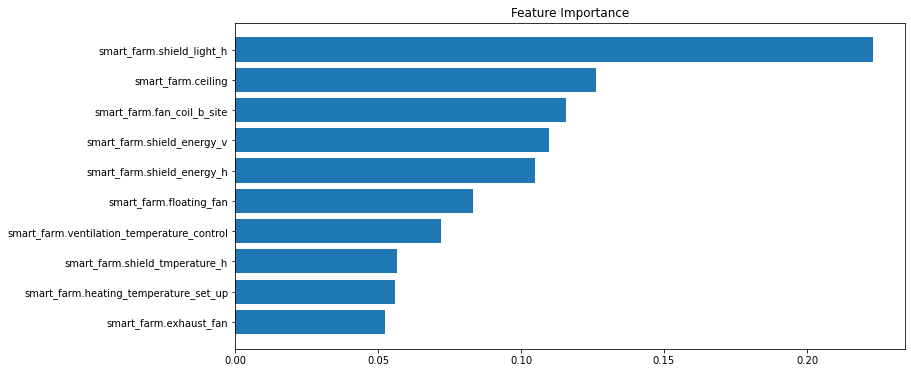

In [8]:
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [11]:
pred_ = xgb_model.predict(X_test)
h1 = []
for i in range(int(len(pred_)/24)):
    h1.append(np.sum(pred_[24*i:24*(i+1)]))
h1
# 4~13, 18~20
h1.insert(0,0)     # 한 번만 클릭!
h1

h11 = h1[4:14] + h1[18:21]
h11
submission1['heat_supply_day1'] = h11
submission1 

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,404.817749,NaN
1,2022,3,5,399.012909,NaN
2,2022,3,6,459.148773,NaN
3,2022,3,7,654.586670,NaN
4,2022,3,8,461.445923,NaN
5,2022,3,9,388.951416,NaN
6,2022,3,10,381.959595,NaN
7,2022,3,11,391.488037,NaN
8,2022,3,12,310.573273,NaN
9,2022,3,13,338.928406,NaN


# Model2

In [12]:
X = training.drop(['일자','smart_farm.heat_supply'], axis=1)
y = training[['smart_farm.heat_supply']].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)   # shuffle은 안 됨. 시간적순서라

X_test = testing.drop(['일자','smart_farm.heat_supply'], axis=1)

In [13]:
xgb_model = xgb.XGBRegressor(n_estimators = 2000, learning_rate = 0.01, max_depth=11, subsample=0.5,colsample_bytree=0.7, random_state = 2000)

xgb_model.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=15)


[0]	validation_0-rmse:24.75896
[1]	validation_0-rmse:24.57070
[2]	validation_0-rmse:24.39359
[3]	validation_0-rmse:24.19929
[4]	validation_0-rmse:24.00654
[5]	validation_0-rmse:23.81874
[6]	validation_0-rmse:23.63418
[7]	validation_0-rmse:23.49247
[8]	validation_0-rmse:23.31353
[9]	validation_0-rmse:23.13337
[10]	validation_0-rmse:22.95353
[11]	validation_0-rmse:22.79123
[12]	validation_0-rmse:22.62875
[13]	validation_0-rmse:22.45809
[14]	validation_0-rmse:22.28546
[15]	validation_0-rmse:22.11699
[16]	validation_0-rmse:21.95519
[17]	validation_0-rmse:21.78942
[18]	validation_0-rmse:21.62168
[19]	validation_0-rmse:21.46029
[20]	validation_0-rmse:21.34080
[21]	validation_0-rmse:21.22783
[22]	validation_0-rmse:21.08495
[23]	validation_0-rmse:20.92797
[24]	validation_0-rmse:20.78193
[25]	validation_0-rmse:20.63724
[26]	validation_0-rmse:20.52369
[27]	validation_0-rmse:20.38436
[28]	validation_0-rmse:20.24595
[29]	validation_0-rmse:20.10131
[30]	validation_0-rmse:19.96381
[31]	validation_0-

[252]	validation_0-rmse:11.15184
[253]	validation_0-rmse:11.15147
[254]	validation_0-rmse:11.14267
[255]	validation_0-rmse:11.14436
[256]	validation_0-rmse:11.13981
[257]	validation_0-rmse:11.13684
[258]	validation_0-rmse:11.13386
[259]	validation_0-rmse:11.13128
[260]	validation_0-rmse:11.12271
[261]	validation_0-rmse:11.12346
[262]	validation_0-rmse:11.12358
[263]	validation_0-rmse:11.12112
[264]	validation_0-rmse:11.11719
[265]	validation_0-rmse:11.11386
[266]	validation_0-rmse:11.11253
[267]	validation_0-rmse:11.10651
[268]	validation_0-rmse:11.10417
[269]	validation_0-rmse:11.09875
[270]	validation_0-rmse:11.10151
[271]	validation_0-rmse:11.10052
[272]	validation_0-rmse:11.09497
[273]	validation_0-rmse:11.09433
[274]	validation_0-rmse:11.09283
[275]	validation_0-rmse:11.08733
[276]	validation_0-rmse:11.08533
[277]	validation_0-rmse:11.08500
[278]	validation_0-rmse:11.07754
[279]	validation_0-rmse:11.07367
[280]	validation_0-rmse:11.07183
[281]	validation_0-rmse:11.06811
[282]	vali

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=2000,
             reg_alpha=0, reg_lambda=1, ...)

Text(0.5, 1.0, 'Feature Importance')

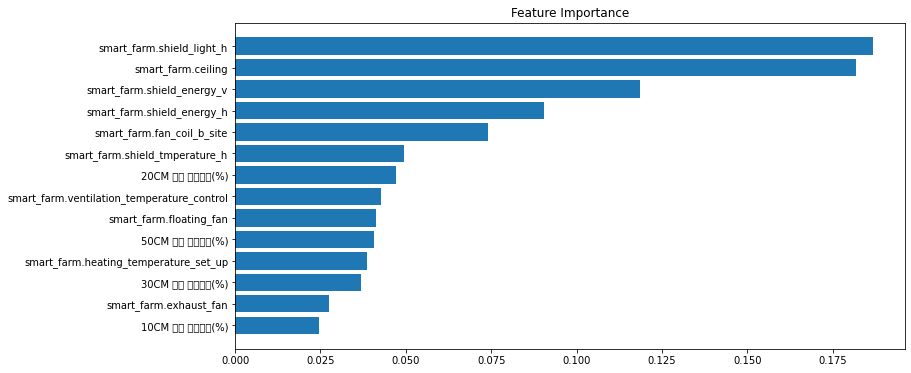

In [14]:
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [16]:
pred_ = xgb_model.predict(X_test)
h1 = []
for i in range(int(len(pred_)/24)):
    h1.append(np.sum(pred_[24*i:24*(i+1)]))
h1
# 4~13, 18~20
h1.insert(0,0)     # 한 번만 클릭!
h1

h11 = h1[4:14] + h1[18:21]
h11
submission1['heat_supply_day2'] = h11
submission1 

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,404.817749,384.555603
1,2022,3,5,399.012909,401.997528
2,2022,3,6,459.148773,418.364929
3,2022,3,7,654.586670,671.993774
4,2022,3,8,461.445923,453.958740
5,2022,3,9,388.951416,399.498779
6,2022,3,10,381.959595,473.138855
7,2022,3,11,391.488037,411.605804
8,2022,3,12,310.573273,399.019806
9,2022,3,13,338.928406,309.848694


In [17]:
submission1.to_csv('220224_xgb.csv', index=False) 